In [305]:
import torch
import os
os.environ["CUDA_VISIBLE_DEVICES"]='1'

from tsl.data import SpatioTemporalDataset, SpatioTemporalDataModule
from tsl.data.preprocessing import StandardScaler
from MMD import mmd_rbf, mmd_linear, mmd_poly
from tsl.datasets import AirQuality
from GRGN.Engines.Generator import Generator
from tsl.data import TemporalSplitter
import pandas as pd
from GRGN.Loss.LogLikelihood import LogLikelihood
from pytorch_lightning import Trainer
from tsl.utils.casting import torch_to_numpy
import matplotlib.pyplot as plt
from typing import Optional
from torch.utils.data import DataLoader

class CustomSpatioTemporalDataModule(SpatioTemporalDataModule):
    def train_dataloader(self, shuffle: bool = False,
                         batch_size: Optional[int] = None) \
            -> Optional[DataLoader]:
        """"""
        return self.get_dataloader('train', shuffle, batch_size)

In [306]:
# filename = '/data/p.magos/TSGen/logs/generation/AirQuality/Best.ckpt'
filename = '/data/p.magos/TSGen/logs/generation/AirQuality/weights_lr_1e3-model-epoch=08-val_loss=3.3271.ckpt'

In [307]:
filename

'/data/p.magos/TSGen/logs/generation/AirQuality/weights_lr_1e3-model-epoch=08-val_loss=3.3271.ckpt'

In [308]:
dataset = AirQuality(impute_nans=True, small=True)

adj = dataset.get_connectivity(**{'method': 'distance',
'threshold': 0.1,
'include_self': False,
'layout': 'edge_index'
})

# instantiate dataset
torch_dataset = SpatioTemporalDataset(target=dataset.dataframe()[-1100:],
                                    covariates=None,
                                    connectivity=adj,
                                    window=1,
                                    stride=1)
splitter = TemporalSplitter(0.5, 0)
scalers = {'target': StandardScaler(axis=(0, 1))}
dm = CustomSpatioTemporalDataModule(
    dataset=torch_dataset,
    splitter=splitter,
    scalers=scalers,
    batch_size=1,
    workers=8)
dm.setup(stage='fit') 

# if cfg.get('in_sample', False):
dm.trainset = list(range(len(torch_dataset)))

/data/p.magos/.pyenv/versions/3.11.9/lib/python3.11/site-packages/tsl/ops/framearray.py:181: FutureWarning: The provided callable <function nanmean at 0x7fa847c30fe0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  nan_mean = df_mean.groupby(conditions[0]).transform(np.nanmean)
/data/p.magos/.pyenv/versions/3.11.9/lib/python3.11/site-packages/tsl/ops/framearray.py:181: FutureWarning: The provided callable <function nanmean at 0x7fa847c30fe0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  nan_mean = df_mean.groupby(conditions[0]).transform(np.nanmean)


In [309]:
# setup generator
generator = Generator.load_from_checkpoint(filename)

In [310]:
trainer = Trainer()

trainer.ckpt_path= filename

generator.freeze()
# trainer.test(generator, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [311]:
print(generator.hparams)

"metrics":          {'LEnc': LogLikelihood(), 'LDec': LogLikelihood(), 'Loss': LogLikelihood()}
"model_class":      <class 'GRGN.GRGNModel.GRGNModel'>
"model_kwargs":     {'n_nodes': 36, 'input_size': 1, 'hidden_size': 16, 'mixture_size': 4, 'mixture_weights_mode': 'weighted'}
"optim_class":      <class 'torch.optim.rmsprop.RMSprop'>
"optim_kwargs":     {'lr': 0.001, 'weight_decay': 0.01}
"scale_target":     True
"scheduler_class":  <class 'torch.optim.lr_scheduler.CosineAnnealingLR'>
"scheduler_kwargs": {'eta_min': 0.0001, 'T_max': 50}


In [312]:
output = trainer.predict(generator, dataloaders=dm.train_dataloader())
output = generator.collate_prediction_outputs(output)
output = torch_to_numpy(output)
y_hat, y_true = (output['y_hat'], output['y'])
# res = dict(test_mae=loss_fn.loss(torch.tensor(y_hat), torch.tensor(y_true)))
# res

Restoring states from the checkpoint path at /data/p.magos/TSGen/logs/generation/AirQuality/weights_lr_1e3-model-epoch=08-val_loss=3.3271.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
Loaded model weights from the checkpoint at /data/p.magos/TSGen/logs/generation/AirQuality/weights_lr_1e3-model-epoch=08-val_loss=3.3271.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Only args ['x', 'edge_index', 'edge_weight'] are forwarded to the model (GRGNModel). 


In [313]:
y_true = torch.Tensor(y_true)

In [314]:
y_true.shape

input = y_true[-1000:-999]
generation = generator.generate(input, torch.tensor(adj[0]), torch.Tensor(adj[1]), None, 500, both_mean=False, kwargs=dict({'scaler': scalers['target']}))

Generating:   0%|          | 0/500 [00:00<?, ?step/s]

Generating: 100%|██████████| 500/500 [00:06<00:00, 78.98step/s]


In [315]:
true = y_true.reshape(y_true.shape[0], y_true.shape[-2])
generation = generation.reshape(generation.shape[0], generation.shape[-2])
generation.shape

torch.Size([500, 36])

In [316]:
X = true[:]
Y = generation
mmd_rbf(torch.Tensor(X), torch.Tensor(Y))

0.0029380684718489647

In [317]:
mmd_linear(torch.Tensor(X), torch.Tensor(Y))

tensor(3388.5820)

In [318]:
mmd_poly(torch.Tensor(X), torch.Tensor(Y))

12940115968.0

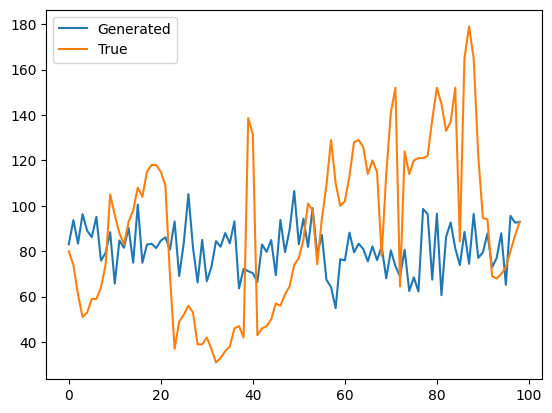

In [319]:
# plt.plot(generation[-500:-400, 35], label='Generated')
# plt.plot(true[-499:-399, 35], label='True')

plt.plot(generation[-99:, 2], label='Generated')
plt.plot(true[-99:, 2], label='True')


plt.legend()

In [320]:
y_true.shape

input = y_true[-100:]
# input = scalers['target'].transform(input)
input.shape
prediction = generator.predict(input, torch.tensor(adj[0]), torch.Tensor(adj[1]), both_mean=True, kwargs=dict({'scaler': scalers['target']}))

Predicting: 100%|██████████| 100/100 [00:01<00:00, 79.06step/s]


In [321]:
prediction = prediction.reshape(prediction.shape[0], prediction.shape[-2])
prediction.shape

torch.Size([100, 36])

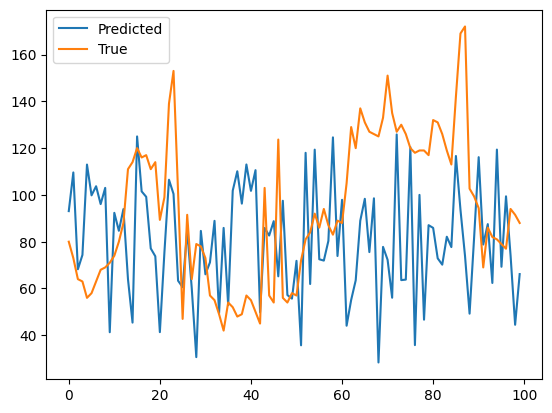

In [322]:
# plt.plot(prediction[-100:, 1], label='Predicted')
# plt.plot(true[-100:, 1], label='True')

plt.plot(prediction[-100:, 35], label='Predicted')
plt.plot(true[-100:, 35], label='True')


# plt.plot(prediction[:, 100], label='Predicted')
# plt.plot(true[-99:, 100], label='True')
plt.legend()

In [323]:
X = true
Y = prediction
mmd_rbf(torch.Tensor(X), torch.Tensor(Y))

0.010938067920506

In [324]:
mmd_linear(torch.Tensor(X), torch.Tensor(Y))

tensor(3532.3918)

In [325]:
err = torch.square(prediction[-99:] - true[-99:])
err.mean()

tensor(2000.0293)

In [326]:
cols = [1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033,1034,1035,1036]
df = pd.DataFrame(generation, columns=cols)

In [327]:
df.to_csv('SynteticAirQualityGRGN.csv', index=False)